# Goal
Tagging efficiencies on Hbb for these different working points

In [12]:
from pathlib import Path
import pandas as pd
import numpy as np
import mplhep as hep
from matplotlib import pyplot as plt

hep.style.use(hep.style.CMS)

In [13]:
lumi_dict = {
    "2022": 7.9714,
    "2022EE": 26.337,
    "2023": 17.981,
    "2023BPix": 9.516,
}


In [14]:
eras = ["2022", "2022EE", "2023BPix", "2023"]
WPs = {"WP1": [0.99, 1.], "WP2": [0.97, 0.99], "WP3": [0.94, 0.97], "WP4": [0.9, 0.94], "WP5": [0.8, 0.9]}
pTs = {"pT200to400": [200, 400], "pT400toInf": [400, np.inf]}

eff_dict = {}
signals = ["gghtobb", "vbfhtobb", "vhtobb", "novhhtobb", "tthtobb"]
signal_label = "mc_hh4b"
# signals = ["data"]
# signal_label = "data"

for era in eras:
    path = Path(f"events/processed_events_{era}.pkl")
    if path.exists():
        df_dict = pd.read_pickle(path)
    else:
        print(f"File {path} not found")
        continue
    
    # Initialize nested dictionary for this era
    eff_dict[era] = {pt_bin: {wp: 0 for wp in WPs.keys()} for pt_bin in pTs.keys()}
    num_total = {pt_bin: 0 for pt_bin in pTs.keys()}
    
    for signal_type in df_dict.keys():
        if signal_type not in signals:
            continue
        df = df_dict[signal_type]
        
        # Process each jet separately to properly pair TXbb scores with pT values
        for jet_idx in [1, 2]:
            TXbbs = df[f"ak8FatJet{jet_idx}TXbb"].to_numpy()
            pTs_vals = df[f"ak8FatJet{jet_idx}Pt"].to_numpy()
            
            # Categorize by pT bins
            for pt_bin, pt_range in pTs.items():
                pt_mask = (pTs_vals >= pt_range[0]) & (pTs_vals < pt_range[1])
                TXbbs_in_pt = TXbbs[pt_mask]
                num_total[pt_bin] += len(TXbbs_in_pt)
                
                for wp, wp_range in WPs.items():
                    wp_mask = (TXbbs_in_pt >= wp_range[0]) & (TXbbs_in_pt < wp_range[1])
                    eff_dict[era][pt_bin][wp] += np.sum(wp_mask)
    
    # Calculate efficiencies
    for pt_bin in pTs.keys():
        if num_total[pt_bin] > 0:  # Avoid division by zero
            for wp in WPs.keys():
                eff_dict[era][pt_bin][wp] /= num_total[pt_bin]
        else:
            print(f"No events found in {era} for {pt_bin}")
            eff_dict[era][pt_bin][wp] = -1

In [15]:
import json
with open(f"eff_WPs-{signal_label}.json", "w") as f:
    json.dump(eff_dict, f)

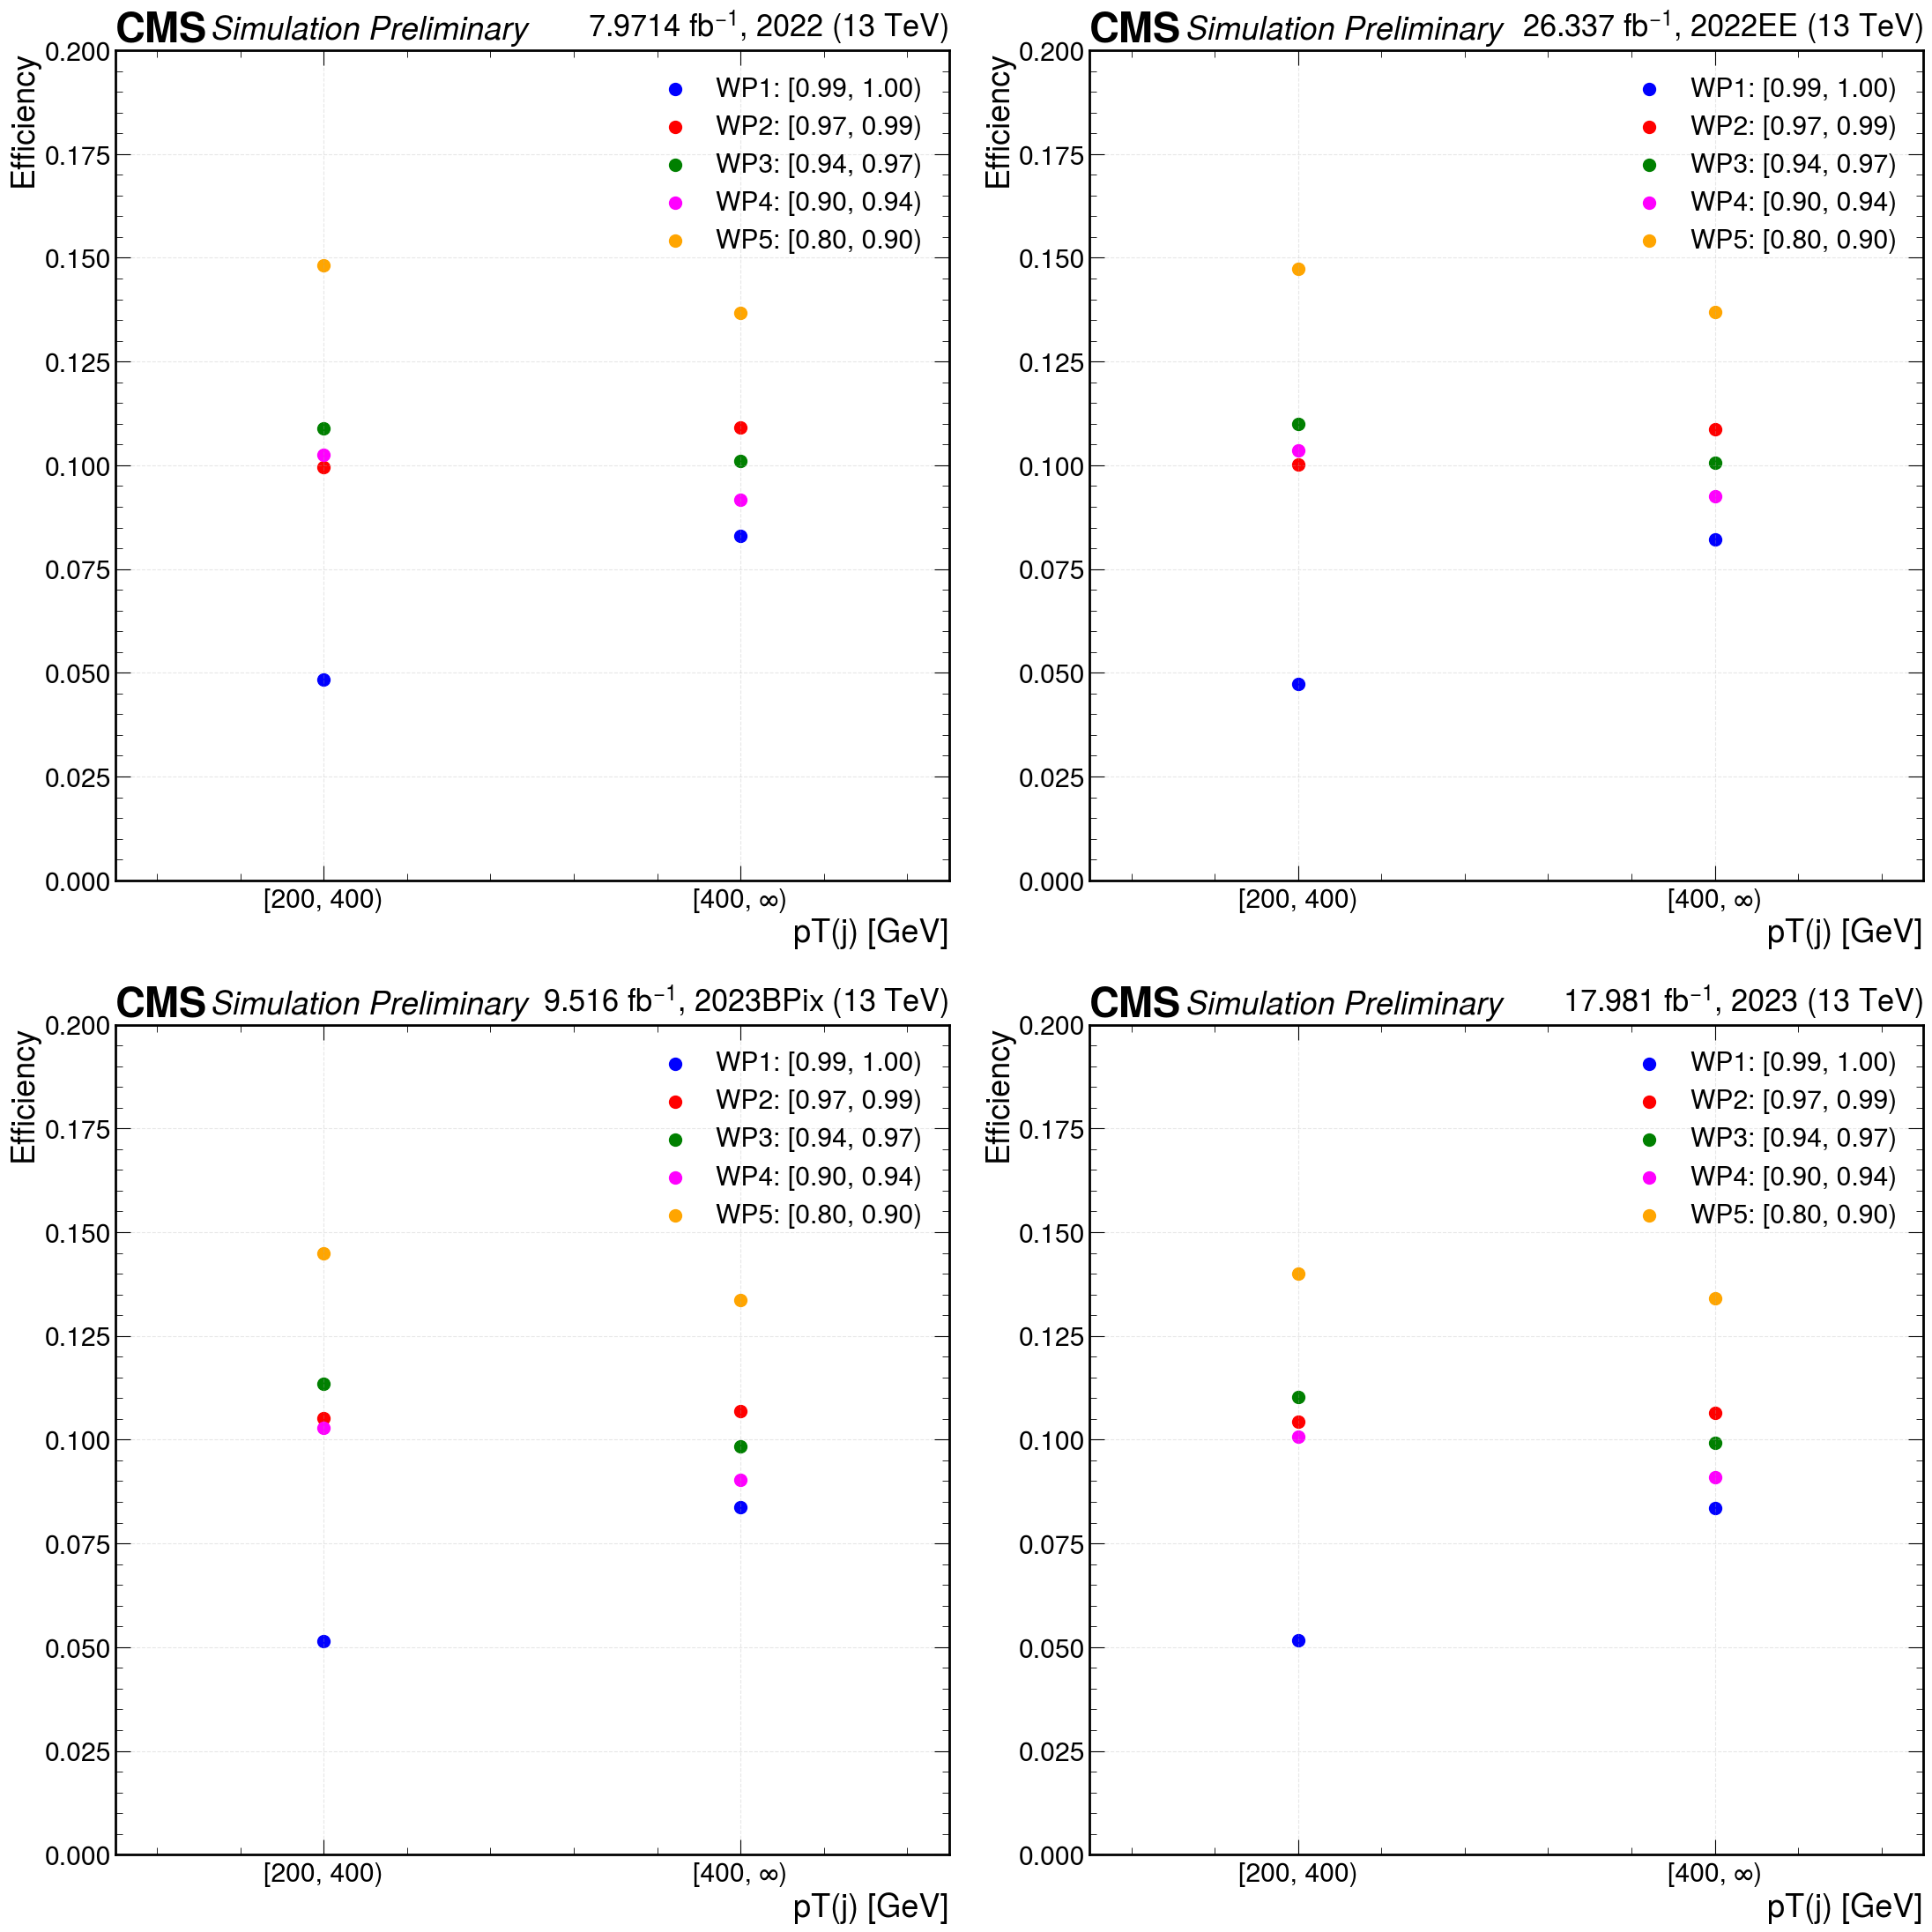

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(22.5, 22.5))

colors = {
    'WP1': 'blue',
    'WP2': 'red',
    'WP3': 'green',
    'WP4': 'magenta',
    'WP5': 'orange'
}

eras = ['2022', '2022EE', '2023BPix', '2023']
luminosities = {
    '2022': '7.9714',
    '2022EE': '26.337',
    '2023': '17.981',
    '2023BPix': '9.516'
}

for idx, era in enumerate(eras):
    i, j = idx // 2, idx % 2
    ax = axs[i, j]
    
    # Plot each WP
    for wp_idx, wp in enumerate(eff_dict[era]['pT200to400'].keys()):
        # Get efficiencies for both pT bins
        eff_low = eff_dict[era]['pT200to400'][wp]
        eff_high = eff_dict[era]['pT400toInf'][wp]
        
        wp_low, wp_high = tuple(WPs[wp])
        label = f"{wp}: [{wp_low:.2f}, {wp_high:.2f})"
        ax.scatter([0, 1], [eff_low, eff_high], color=colors[wp], marker='o', label=label, s=100)
    
    # Customize each subplot
    ax.set_ylim(0, 0.2)
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylabel("Efficiency")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['[200, 400)', '[400, ∞)'])
    
    # Add era labels and luminosity
    lumi = lumi_dict[era]
    hep.cms.label("Preliminary", ax=ax, lumi=lumi, year=era)
    
    ax.set_xlabel("pT(j) [GeV]")
        
    ax.grid(True, linestyle='--', alpha=0.3)
    # ax.legend(loc='center right')
    ax.legend()

plt.tight_layout()
plt.savefig(f"eff_WPs-{signal_label}.pdf")
plt.show()